# AllLife Bank Customer Segmentation 

## Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

## Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


## Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

## Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

### Importing necessary libraries

In [1]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

### Read the dataset

In [14]:
# loading the dataset
data = pd.read_csv("Megaorginal.csv")

### View the random 10 rows of the dataset.

In [15]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,first,second,third,fourth,fifth,mega
65,11,16,23,24,30,24
35,3,14,40,53,54,8
42,15,19,27,35,57,17
93,10,15,20,66,68,18
38,7,21,24,41,65,24
39,11,41,43,44,65,13
54,8,15,21,27,61,8
86,7,8,26,30,39,17
31,3,12,14,18,32,4
77,2,5,30,46,61,8


### Understand the shape of the dataset.

In [7]:
data.shape

(660, 7)

* The dataset has 660 rows and 7 columns.
* Sl_No and Customer Key columns add no value on data analysis, therefore we will drop both columns
* Avergage Credit limit can create bias on data analysis,  we will scale the all dataset.
* Since we are segmenting credit card customers we will do Unsupervised learning.

In [16]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [9]:
# dropping the serial no and customer key columns as they does not provide any information
df.drop(["Sl_No","Customer Key"], axis=1, inplace=True)

### Check the data types of the columns for the dataset.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


**Observations**

- All columns are numerical datatype.
- No null values are observed.

### Summary of the dataset.

In [10]:
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


**Observations**

- Customers have Average credit limit ranging from 3K to 200K with mean limit of 34K.
- Customers have total credit cards raning from 1 to 10 with  avg 2 cards.
- Customer make  0 to 5 times  visit bank with average of 2 times yearly.
- Customers make 0 to 15 times online visit with average of 2 times yearly.
- Customers make 0 to 10 calls with avg of 3 calls yearly.

### Checking for Null Values

In [11]:
# checking for missing values
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- There are no missing values in our data

# EDA

### Univariate Analysis

In [17]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts(ascending=False).index,
        #order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

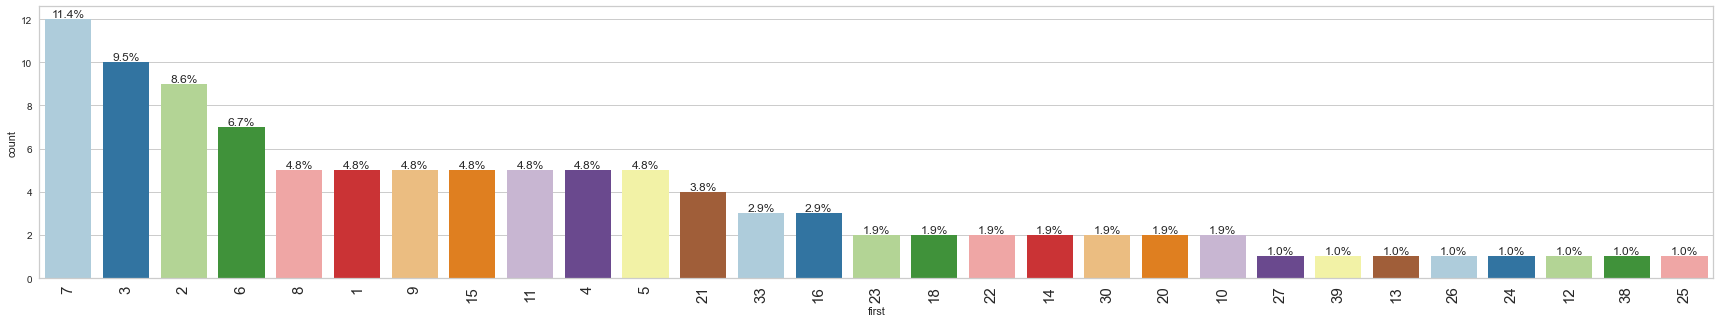

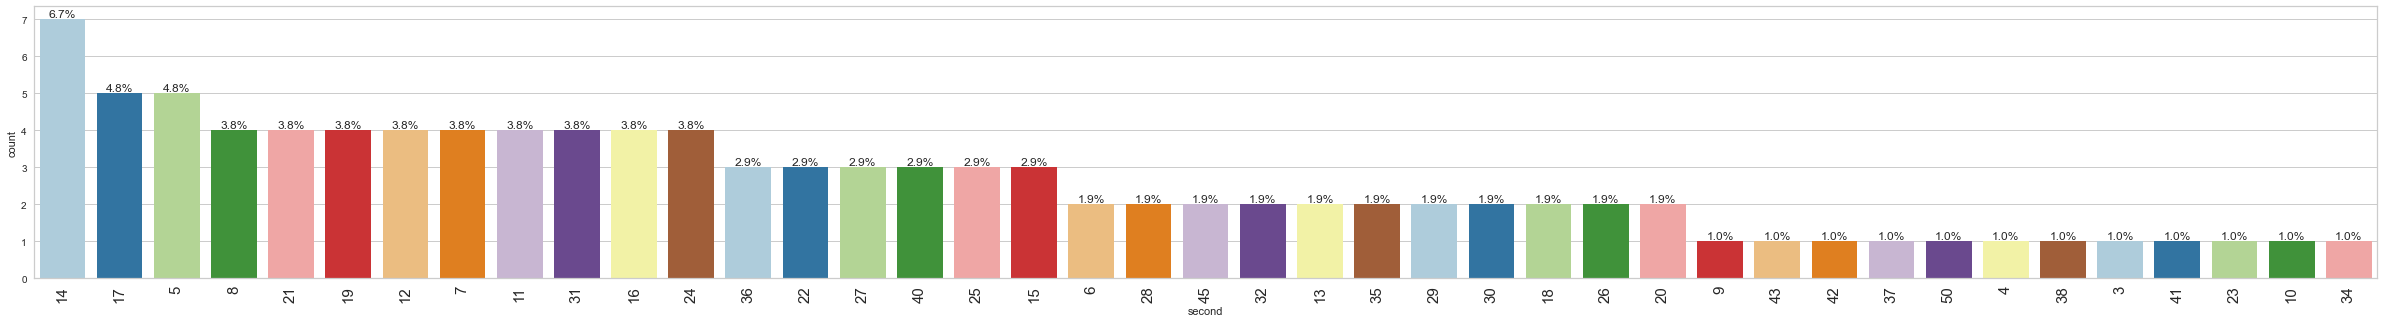

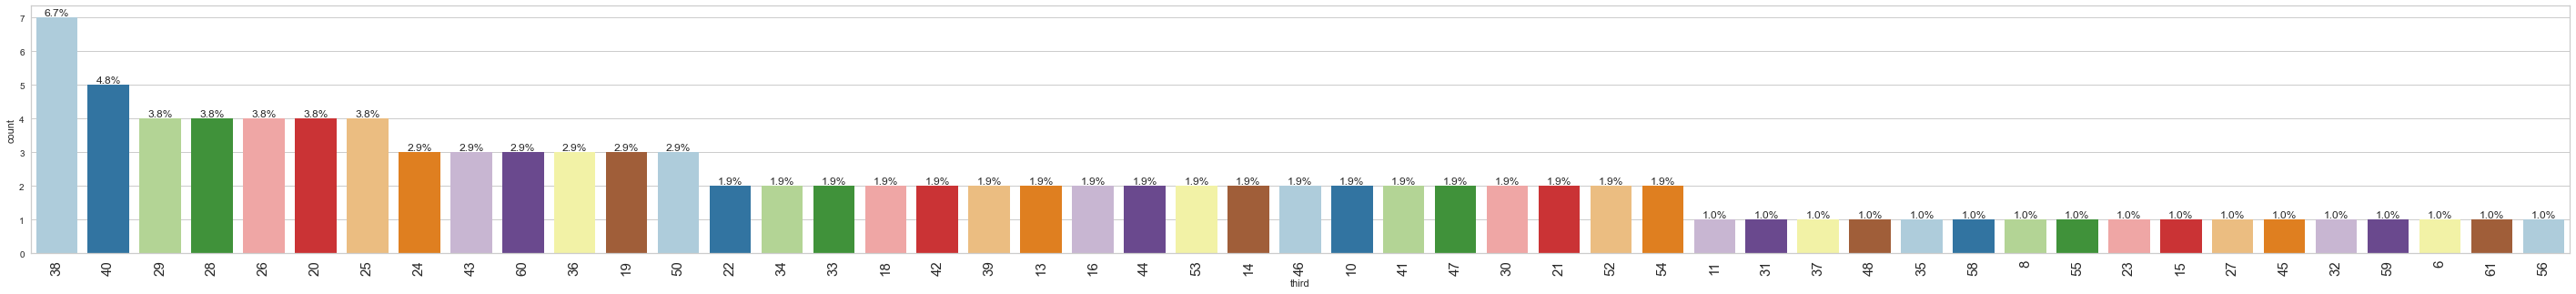

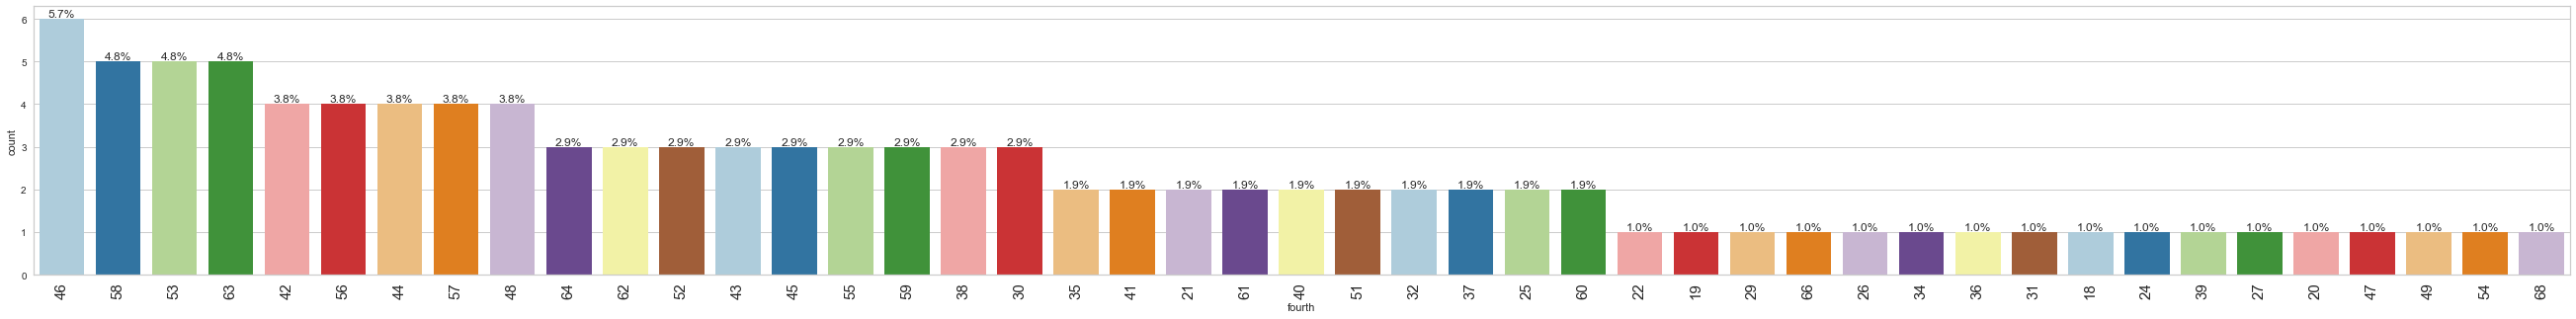

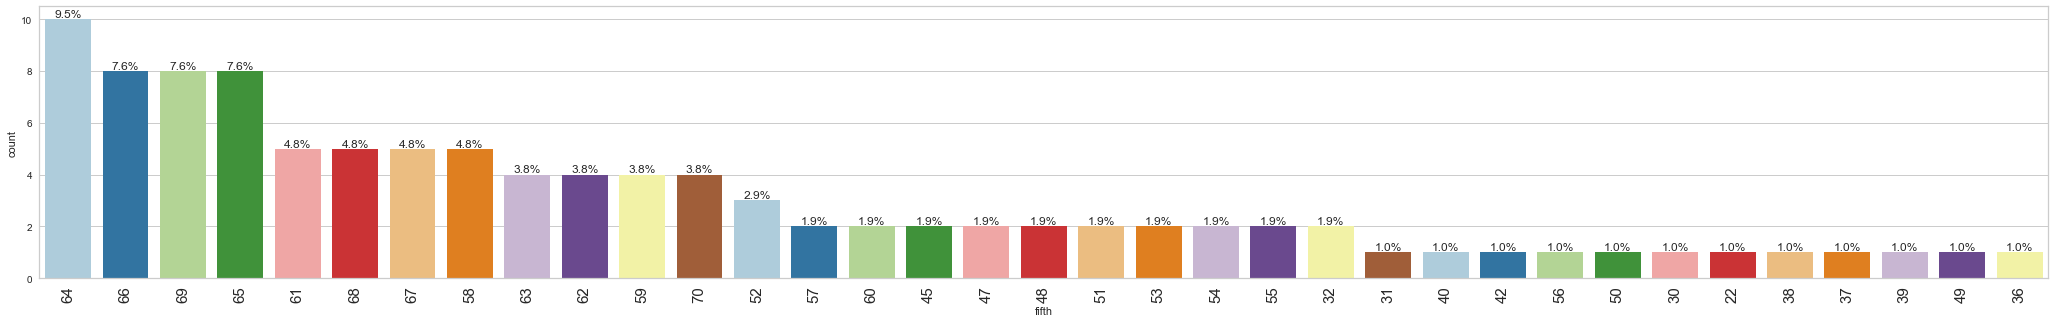

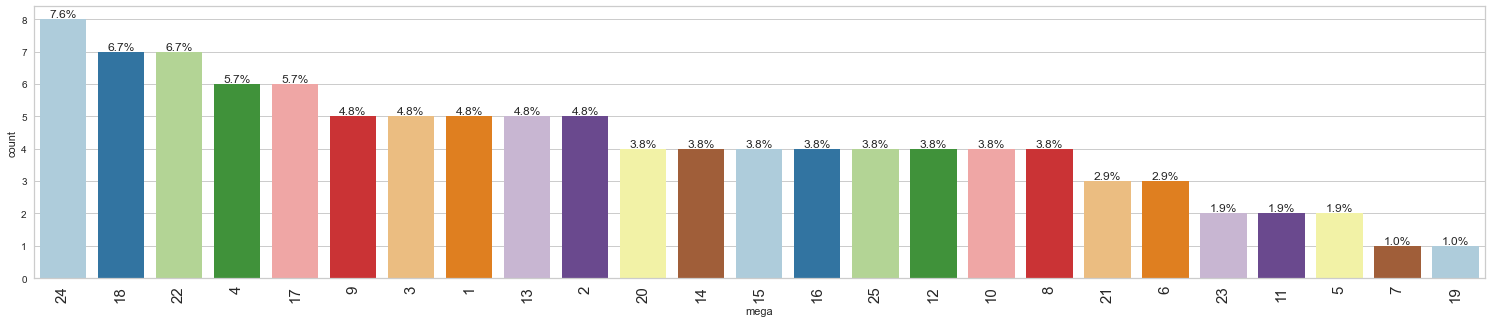

In [18]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
for item in num_col:
    labeled_barplot(df, item, perc=True)

**Observations**

- Around 23% of customers have 4 credit cards and  followed by 17 % with 6 credit cards and 15% cards.
- More than 5% of customers have  average credit limit of $8K and very less number of customers have higher average credit limit.
- More than 20% customers made 2 visited online per year for banking.
- More than 16% customers made  4 calls per year.

### Bivariate Analsysis

**Let's check for correlations.**

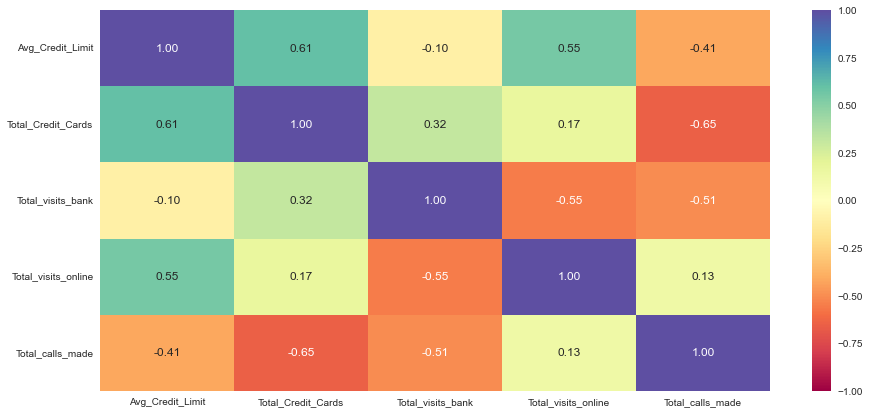

In [16]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**

- Average credit limit have high positive correlaton with Total no of credit cards and Total online visits.
- Total no of cards and Total no of visits have slight positive correlation.

## K-Means Clustering 

In [13]:
# copy of preprocess dataset
subset_df=df.copy()

In [14]:
#create a variable to get list of numerical columns
num_col=df.select_dtypes(include=np.number).columns.tolist()

### Feature scaling

In [15]:
# apply scaler function to normalize the data as Average credit limit have higher value can create bias on our analysis
scale = StandardScaler()
subset_df[num_col]=scale.fit_transform(subset_df[num_col])
n_subset_df = subset_df[num_col]
n_subset_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9429600194368428
Number of Clusters: 7 	Average Distortion: 0.9093922362871227
Number of Clusters: 8 	Average Distortion: 0.8870355174187714


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

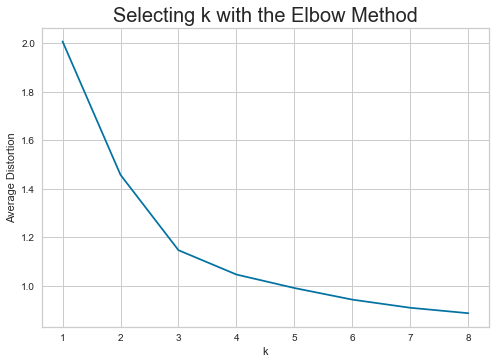

In [137]:
clusters = range(1, 9)
meanDistortions = []  # Create a empty list

for k in clusters:
    model = KMeans(n_clusters=k)  # Initialize KMeans
    model.fit(subset_df)  # Fit kMeans on the data
    prediction = model.predict(subset_df)  # Predict the model on the data
    distortion = (
        sum(np.min(cdist(subset_df, model.cluster_centers_, "euclidean"), axis=1))
        / df.shape[0]  # Find distortion
    )

    meanDistortions.append(
        distortion
    )  # Append distortion values to the empty list created above

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Title of X-axis
plt.ylabel("Average Distortion")  # Title of y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot

**In the above plot, the elbow is seen for K=2,3 and 4 but if you observe the Average distortion results, there is some drop in distortion at K= 3** 

**Q) How do we determine the optimal K value when the elbows are observed at 3 or more K values from the elbow curve?**

**To make a better decision about the number of clusters, we can look at the silhouette score for different K values.**

### What is silhouette score?

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. 
* Silhouette score near -1 indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2, silhouette score is 0.41842496663230405
For n_clusters = 3, silhouette score is 0.5157182558882754
For n_clusters = 4, silhouette score is 0.35566706193773706
For n_clusters = 5, silhouette score is 0.2717470361094591
For n_clusters = 6, silhouette score is 0.25549904334627477
For n_clusters = 7, silhouette score is 0.24818052759029105
For n_clusters = 8, silhouette score is 0.22706891053602563
For n_clusters = 9, silhouette score is 0.21957942846946396


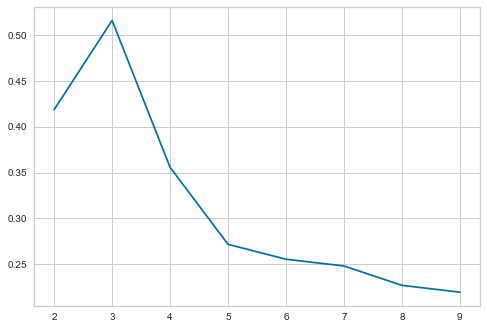

In [138]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((subset_df))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_df, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.Let's do deeper investigation for different K values using  SilhouetteVisualizer**

### How to interpret the results of SilhouetteVisualizer?

Below are the points that every cluster needs to satisfy for selecting the optimal K-value.
  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score
  
**Note** 
1. Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)
2. Horizontal line refers to the Silhouette score of each cluster.
3. Dotted red line is an Average Silhouette score. 

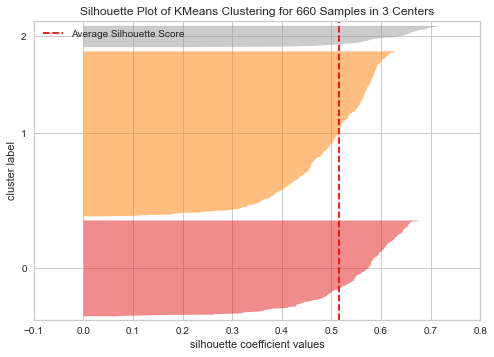

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [139]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that  3 cluster labels silhoutte score is more than Average silhouette score , so k=3 will consider to be an appropriate value. Let's visualize for k=2**.

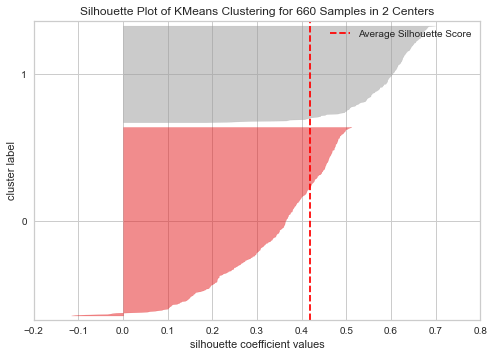

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can observe that cluster lable with 0 have negtive value, so k=2 will not be an appropriate value. Let's visualize for k=5**. 

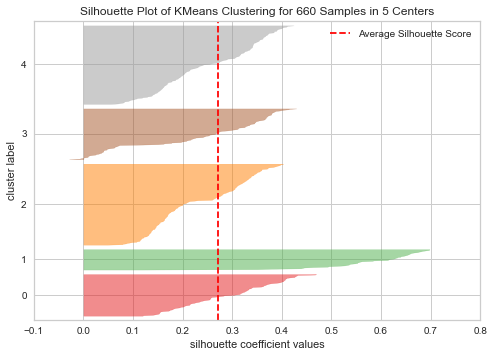

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [141]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that all 5 cluster labels have positive values but average Silhouette score is less  when compared k=3, so k=5 will not be an appropriate value Let's visualize for k=4.**

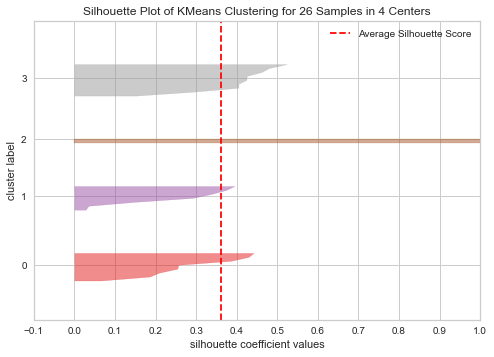

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 26 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_df)
visualizer.show()

* **From the above plot, we can see that all 5 cluster labels have positive values but average Silhouette score is less  when compared k=3, so k=4 will not be an appropriate value.** 

* **We can see from the plot above that all the clusters meet the requirements. So, let's take 3 as the appropriate no. of clusters(K) as the silhouette score is high enough for all the 3-clusters(above average silhouette score), and there is a knick at 3 in the elbow curve.**

### Applying KMeans clustering for k=2

In [18]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_df)

KMeans(n_clusters=3, random_state=0)

In [19]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

In [20]:
# adding kmeans cluster labels to the scaled dataframe
subset_df["K_means_segments"] = kmeans.labels_

### Cluster Profiling

In [22]:
cluster_profile = df.groupby("K_means_segments").mean()

In [112]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [23]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


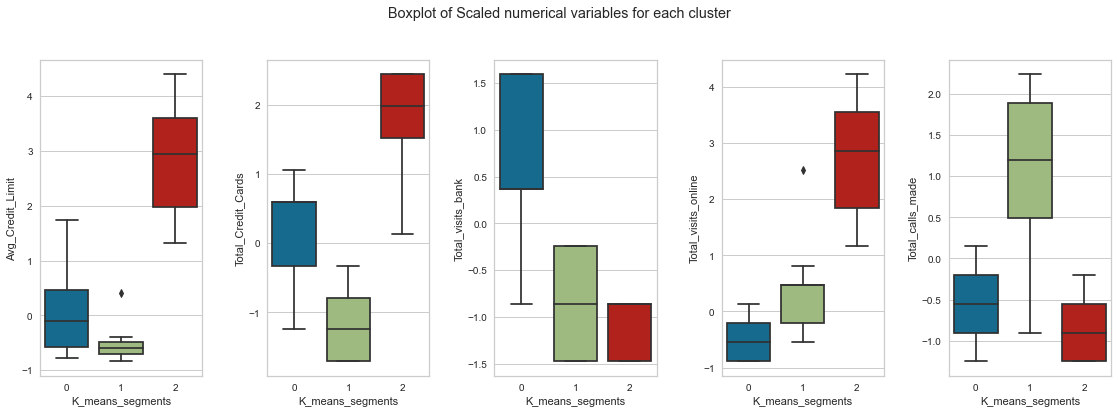

In [33]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of Scaled numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=subset_df[num_col[counter]], x=subset_df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

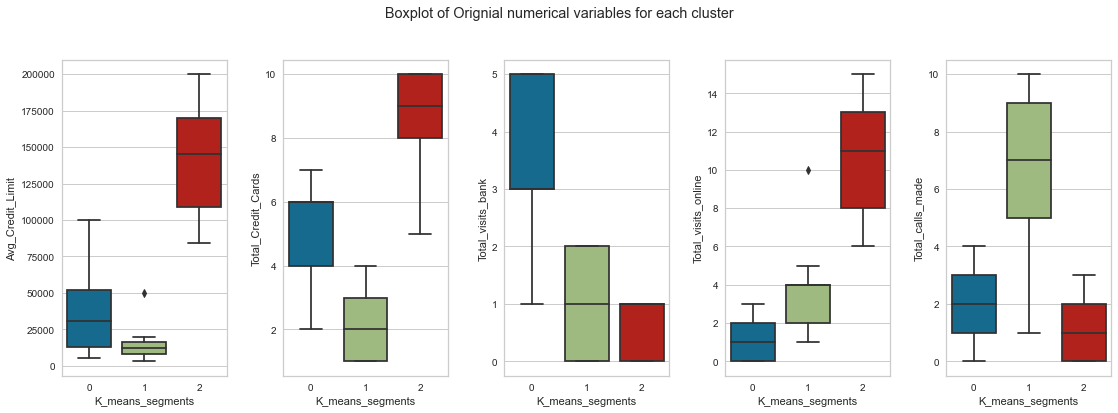

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of Orignial numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - Average credit limits are low to moderate range.
    - Moderate total no of credits cards.
    - Higher bank visits per year.
    - Very less online visits per year.
    - Low to moderate Total calls made per year


- **Cluster 1**:
    - Average credit limits is very low.
    - Low total no of credits cards.
    - low bank visits per year.
    - low online visits per year.
    - Higher total calls made per year
    
- **Cluster 2**:
    - Average credit limits are  very low in range.
    - Higher total no of credits cards.
    - Very low bank visits per year.
    - Higher online visits per year.
    - Low no of calls made per year.

### Business Recommendations

- **Cluster 0**: These are the customers with low usage of credit cards. **Marketing team should run campaign This cluster of customers and encourage them to uses online services  and offer promotions to improve credit card usage.**

- **Cluster 1**: These are the customers with Moderate usage of credit cards. **There is scope Marketing team run campaign This cluster of customers and encourage them to uses online services and offer Credit line increase and promotions to sell new credit card products.**

- **Cluster 2**: These are the customers with excellent usage of credit cards and based usage of online services they pay their  bills on time. **There is room Marketing team run campaign and offer incenstives like more cash back to increase credit usage.**

## Hierarchical Clustering

In [25]:
#Make a copy of original data without previously applied Kmeans values.
df1=df.drop(["K_means_segments"],axis=1).copy()

In [26]:
df1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [27]:
#create a variable to get list of numerical columns
num_col=df1.select_dtypes(include=np.number).columns.tolist()

In [28]:
# make copy of original data before applying scaler function
subset_df1=df1.copy()

In [29]:
# apply scaler function to normalize the data
scale = StandardScaler()
subset_df1[num_col]=scale.fit_transform(subset_df1[num_col])
n_subset_df1 = subset_df1[num_col]
n_subset_df1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


In [30]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_df1, columns=df1.columns)

In [180]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8788676940541079.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8860521900934342.
Cophenetic correlation for Euclidean distance and average linkage is 0.9168725782090766.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9133393931042242.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8978014062578786.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8623270916886306.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9160784250471772.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9109044268579872.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8959952526724226.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6550023123197861.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8467618899578884.
Cophenetic co

In [181]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9168725782090766, which is obtained with Euclidean distance and average linkage.


**Let's explore different linkage methods with Euclidean distance only.**

In [182]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8788676940541079.
Cophenetic correlation for complete linkage is 0.8860521900934342.
Cophenetic correlation for average linkage is 0.9168725782090766.
Cophenetic correlation for centroid linkage is 0.9134704636213649.
Cophenetic correlation for ward linkage is 0.774233615737438.
Cophenetic correlation for weighted linkage is 0.9133393931042242.


In [183]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9168725782090766, which is obtained with average linkage.


**Observations**

- We see that the cophenetic correlation is maximum with euclidean distance and average linkage.
- The cophenetic correlation with Euclidean distance and centriod linkage is slightly less than the combination with maximum cophenetic correlation. 

**Let's see the dendrograms for the different linkage methods.**

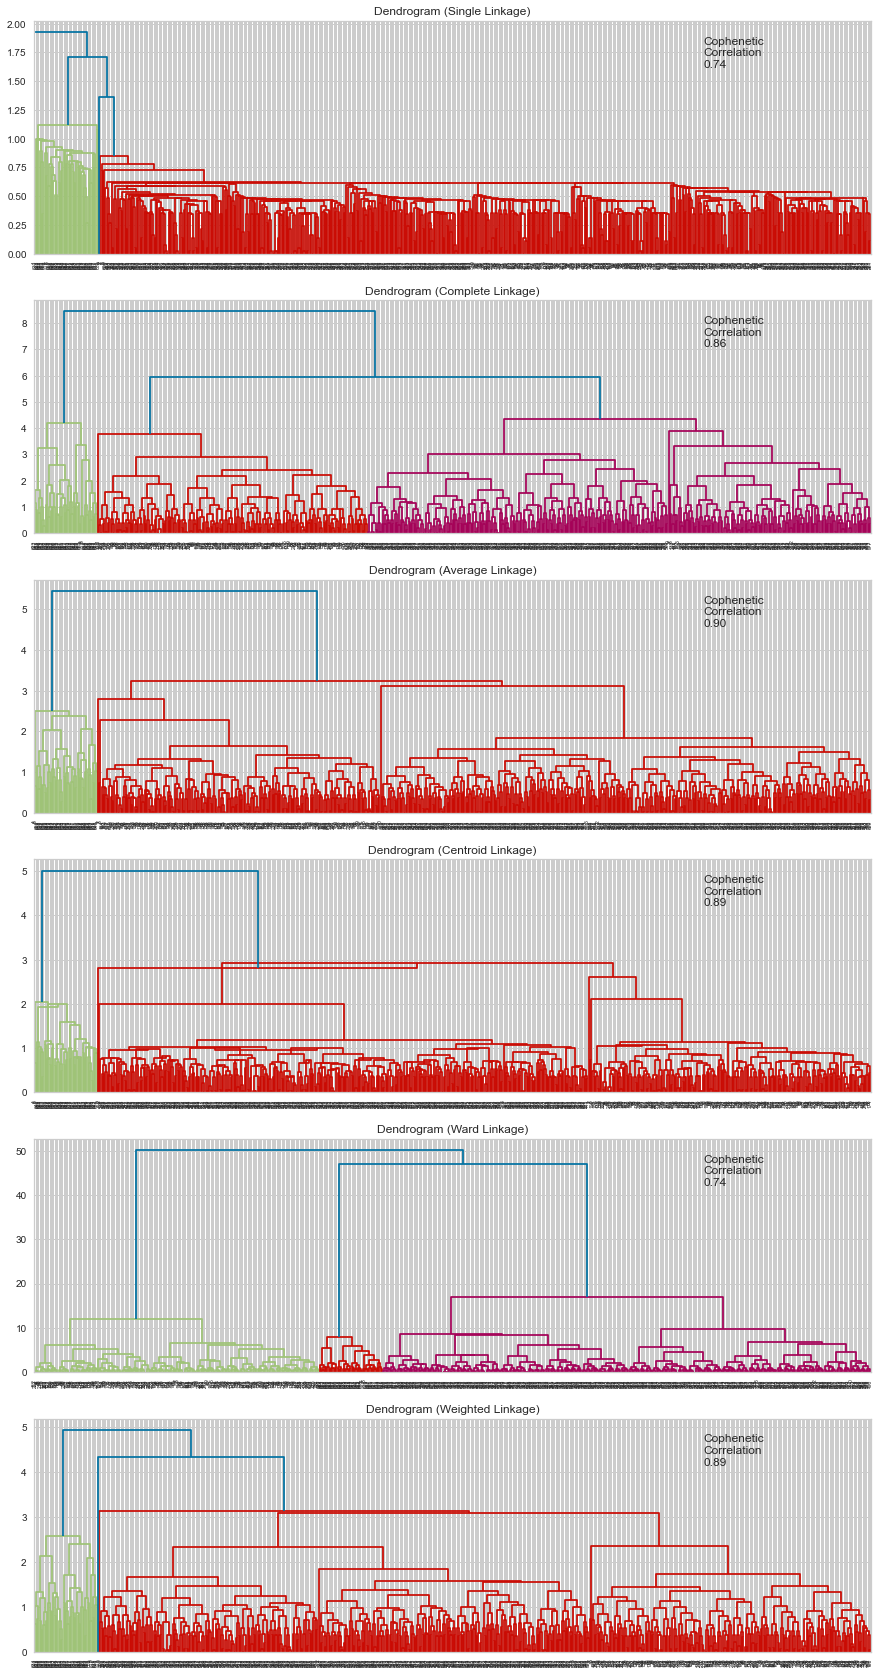

In [184]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [185]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739122
1,complete,0.859973
2,average,0.897708
3,centroid,0.893939
4,ward,0.741516
5,weighted,0.886175


**Let's see the dendrogram for Chebyshev and CityBlock distances with average and weighted linkage methods (as they gave high cophenetic correlation values).**

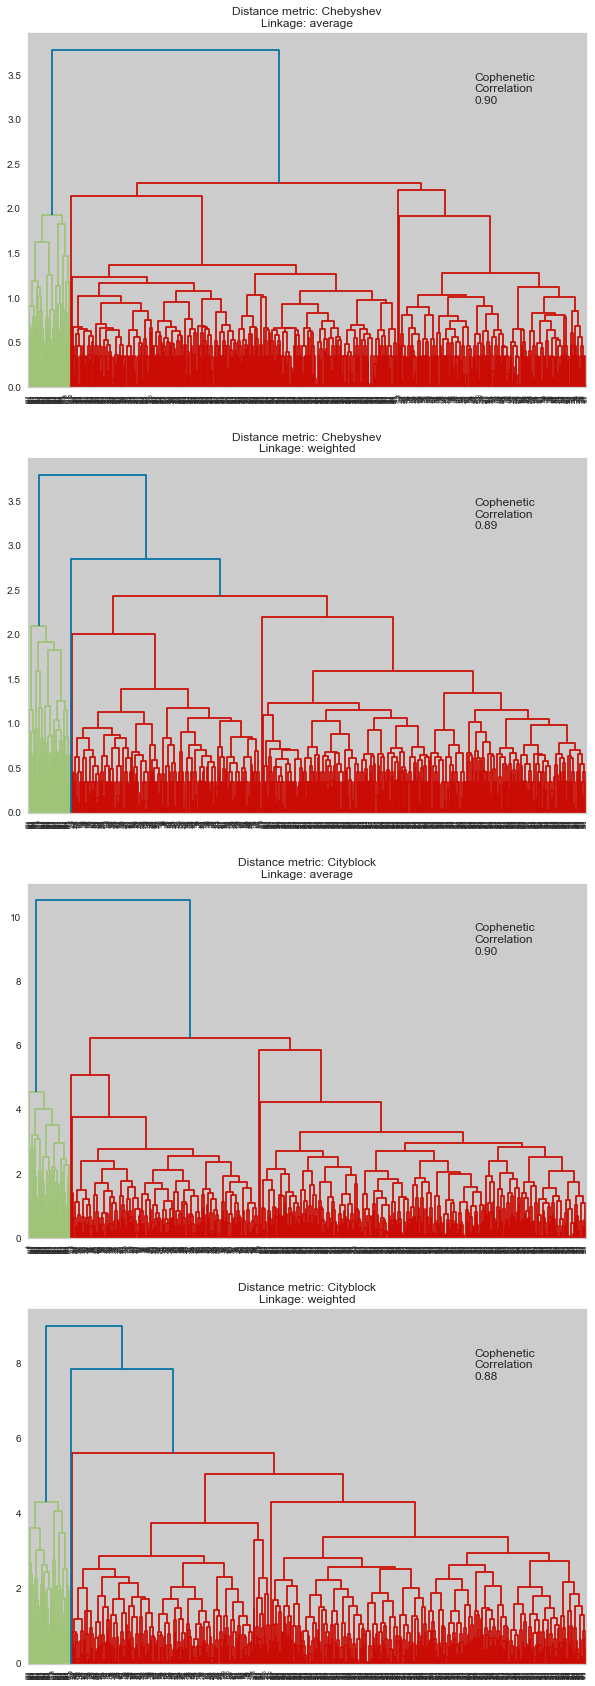

In [187]:
# list of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with Average linkage with euclidean distance gave us separate and distinct clusters.
- 3 would be the appropriate number of the clusters from the dendrogram with Average linkage method.

**Let's create 3 clusters.**

In [31]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [190]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df1["HC_Clusters"] = HCmodel.labels_

## Cluster Profiling

In [191]:
cluster_profile = df1.groupby("HC_Clusters").mean()

In [192]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_Clusters,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


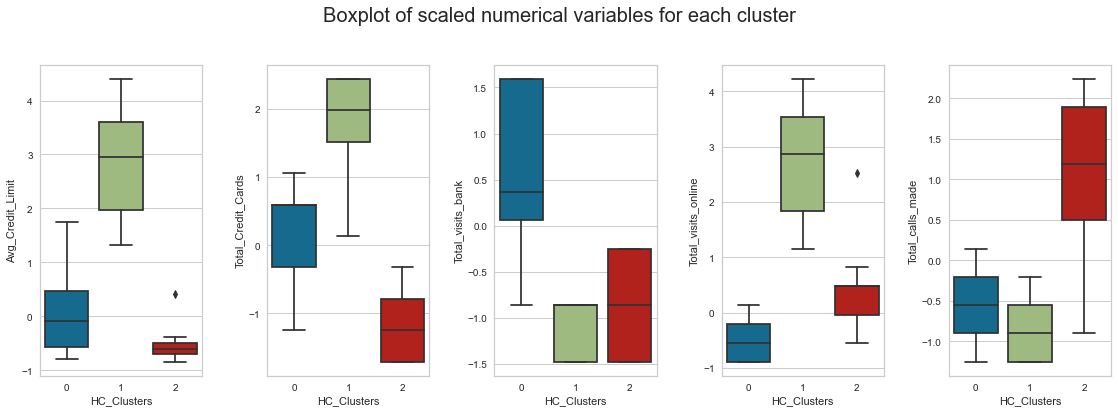

In [193]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

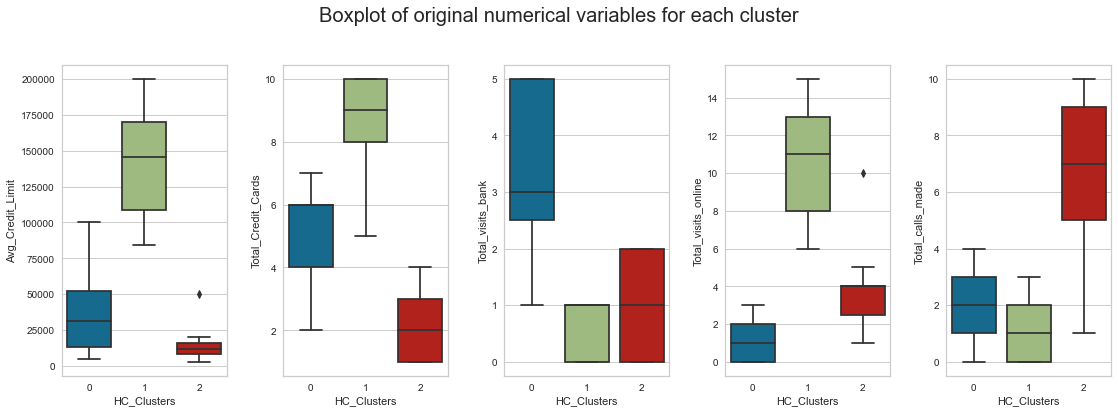

In [194]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df1[num_col[counter]], x=df1["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

- **Cluster 0**:
    - Average credit limits are low to moderate range.
    - Moderate total no of credits cards.
    - Higher bank visits per year.
    - Very less online visits per year.
    - Low to moderate Total calls made per year

- **Cluster 1**:
    - Average credit limits are higher in range.
    - Higher total no of credits cards.
    - Very low bank visits per year.
    - Higher online visits per year.
    - Very total calls made per year
    
- **Cluster 2**:
    - Average credit limits are  very low in range.
    - Very low to moderate total no of credits cards.
    - Low bank visits per year.
    - Moderate online visits per year.
    - Higher calls made per year.

    

### Business Recommendations

- **Cluster 0**: These are the customers with low usage of credit cards. **Marketing team should run campaign This cluster of customers and encourage them to uses online services  and offer promotions to improve credit card usage.**

- **Cluster 1**: These are the customers with excellent usage of credit cards and based usage of online services they pay their  bills on time. **There is room Marketing team run campaign and offer incenstives like more cash back to increase credit usage.**

- **Cluster 2**: These are the customers with Moderate usage of credit cards. **There is scope Marketing team run campaign This cluster of customers and encourage them to uses online services  and offer promotions to sell new credit card products.**

### K-means vs  Hierarchical Clustering

* Both K-means and Hierarchical clustering exibhited similiar results.